I was inspired by [@twiecki](https://github.com/twiecki) and his great [post](http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/) about Bayesian neural networks. But I thought that that way of creating BNNs is not obvious and easy for people. That's why I decided to make [Gelato](https://github.com/ferrine/gelato) that is a bridge for [PyMC3](https://github.com/pymc-devs/pymc3) and [Lasagne](https://github.com/Lasagne/Lasagne).
I will use his convolution bnn from the post as an example of how to use gelato API.

In [1]:
%env THEANO_FLAGS=device=cuda0
import matplotlib.pyplot as plt
%matplotlib inline
import gelato
import theano
import theano.tensor as tt
theano.config.warn_float64 = 'warn'
import numpy as np
import lasagne
import pymc3 as pm

env: THEANO_FLAGS=device=cuda0


Using cuDNN version 5105 on context None
Mapped name None to device cuda0: Tesla K40m (0000:02:00.0)


## Load Data

In [2]:
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    mnist = fetch_mldata('MNIST original')
    data = mnist['data'].reshape((70000, 1, 28, 28))
    target = mnist['target']
    # We can now download and read the training and test set images and labels.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=10000)
    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

print("Loading data...")
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
total_size = X_train.shape[0]

Loading data...


## Create priors for weights (Spec classes)
Gelato has a flexible way to define a prior on weight instead of just shared variable. It supports a lot of features, listed below.

Basicly, Specification (`Spec`) is a delayed expression that depends on shape. I made possible to combine them with tensor operations, manipulate shape and apply custom delayed functions. 

In [3]:
from gelato.specs import NormalSpec
expr = NormalSpec() * NormalSpec().with_shape(())
expr

SpecOp.__mul__

`Spec` behaves like a tensor and has the same methods 

In [4]:
dir(expr)[70:80]

['arccosh',
 'arcsin',
 'arcsinh',
 'arctan',
 'arctanh',
 'argmax',
 'argmin',
 'args',
 'argsort',
 'astype']

Methods are used as usually, but instead of a tensor we get another `Spec` instance.

In [5]:
expr.argmin()

SpecOp.argmin

These operations are dalayed until user calls `expr(shape)`. When that happens this shape is passed to all defined specs in expression tree. This tree is evaluated and pymc3 variables are created, one per spec instance and shape for it (there exsist some corner cases when one spec instance can get 2 different shapes).

In [6]:
with pm.Model() as model:
    expr((100, 2))

In [7]:
model.vars

[auto_1, auto_4]

Note that in example above we specified one variable without shape and other `.with_shape(())`. So when expression is evaluated this custom shape replaces the shape that was provided in `__call__`.

In [8]:
list(map(lambda v: v.dshape, model.vars))

[(100, 2), ()]

More complex cases can require more accurate shape handling. This can be achived with `tags`.

In [9]:
expr = NormalSpec().with_tag('one') * NormalSpec().with_tag('two') + NormalSpec()

Now if we try to call the expression without tags or we will get __KeyError__. Unspecified shape is *default*  tag.

In [10]:
with pm.Model() as model:
    expr(dict(one=(100, 2), two=(), default=(100, 1)))
list(map(lambda v: v.dshape, model.vars))

[(100, 2), (), (100, 1)]

Sometimes it is usefull to change shape with a function, it maps shape to shape

In [11]:
expr = NormalSpec().with_shape(lambda s: (1,) * len(s)) * NormalSpec()

In [12]:
with pm.Model() as model:
    expr((10, 10))
list(map(lambda v: v.dshape, model.vars))

[(1, 1), (10, 10)]

If you need some more complex transformation other than builtin tensor operations you can use a simple wrapper over a function

In [13]:
from gelato.specs import as_spec_op
spec_det = as_spec_op(theano.tensor.nlinalg.det)
spec_det

functools.partial(<class 'gelato.specs.base.SpecVar'>, <theano.tensor.nlinalg.Det object at 0x7fa21c853390>)

Determinant will be taken only after `__call__`

In [14]:
spec_det(expr)

SpecOp.Det

### Disclamer
I have to note that Gelato has some overhead magic with wrappring lasagne layers. Espessially there is no need to use gelato layer if you pass gelato `Spec` class to Lasagne layer to define a weight. But using them happens to be very convenient. There is a handy function `set_default_spec` that declares what prior to use if none specified. Let's see how it works.

## Priors
In this setup I decided to use hyperprior to show it can be done very easily. Moreover it worked better for me, no need to choose regularization constant.

In [34]:
from gelato.specs import NormalSpec, LognormalSpec, set_default_spec
# Now every layer without passed specs will use `NormalSpec(sd=hyper)` as a prior
hyper = LognormalSpec(sd=10).with_shape(())
set_default_spec(NormalSpec(sd=hyper))

## Network

The following print output should make you think *"What's the hell is going on? Is it real?"*

In [35]:
print(issubclass(gelato.layers.InputLayer, pm.Model) and 
      issubclass(gelato.layers.Conv2DLayer, pm.Model))
print(issubclass(gelato.layers.InputLayer, lasagne.layers.Layer) and 
      issubclass(gelato.layers.Conv2DLayer, lasagne.layers.Layer))

True
True


Yes, Gelato layers are Models and Layers at the same time. Moreover context is taken from the previous layers so that you no more need `with model: ...` construction for most usecases.

## Minibatches
I prefer storing all my dataset in GPU memory if it is possible to avoid unnessesary data transfers. It is possible with out of the bos pymc3 minibatches

In [36]:
input_var = pm.Minibatch(X_train, 100, dtype='float32')
target_var = pm.Minibatch(y_train, 100, dtype='int32')

In [37]:
network = gelato.layers.InputLayer(shape=(None, 1, 28, 28),
                                    input_var=input_var)
network = gelato.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.tanh)

# Max-pooling layer of factor 2 in both dimensions:
network = gelato.layers.MaxPool2DLayer(network, pool_size=(2, 2))

# Another convolution with 32 5x5 kernels, and another 2x2 pooling:
network = gelato.layers.Conv2DLayer(
    network, num_filters=32, filter_size=(5, 5),
    nonlinearity=lasagne.nonlinearities.tanh)

network = gelato.layers.MaxPool2DLayer(network, 
                                        pool_size=(2, 2))

n_hid2 = 176
network = gelato.layers.DenseLayer(
    network, num_units=n_hid2,
    nonlinearity=lasagne.nonlinearities.tanh,
)

n_hid3 = 64
network = gelato.layers.DenseLayer(
    network, num_units=n_hid3,
    nonlinearity=lasagne.nonlinearities.tanh,
)

# Finally, we'll add the fully-connected output layer, of 10 softmax units:
network = gelato.layers.DenseLayer(
    network, num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax,
)

prediction = gelato.layers.get_output(network)

# Gelato layers are designed to simlify the whole process
# and are pm.Models as well as lasagne.layer.Layer
# You can work in the contest of the last defined layer to define likelihood
with network:
    likelihood = pm.Categorical('out', 
                   prediction,
                   observed=target_var,
                   total_size=total_size)

We now minimize the following objective
$$-1 * ELBO=KL[q(w|mu,rho)||p(w)] - E_q[log p(D|w)]$$

Getting ELBO for model and optimizing it is quite easy and can be cone just in few lines. As we will perform batch training we have to say what population size we have for observed var or else we'll get invalid approximation.

Let's see' what we've created

In [38]:
network.vars

[DenseLayer_8770668666937_W:62_log__,
 DenseLayer_8770668666937_W,
 DenseLayer_8770668666937_b]

Seems something went wrong:(

That's not the thing you expect, but that's just a nested model.
You can find your root model accessing `network.root`. It stores all parameters, potentials, likelihood, etc

In [39]:
network.root.vars

[Conv2DLayer_8770666142861_W:46_log__,
 Conv2DLayer_8770666142861_W,
 Conv2DLayer_8770666142861_b,
 Conv2DLayer_-9223363266188632965_W:50_log__,
 Conv2DLayer_-9223363266188632965_W,
 Conv2DLayer_-9223363266188632965_b,
 DenseLayer_8770666122735_W:54_log__,
 DenseLayer_8770666122735_W,
 DenseLayer_8770666122735_b,
 DenseLayer_8770666122553_W:58_log__,
 DenseLayer_8770666122553_W,
 DenseLayer_8770666122553_b,
 DenseLayer_8770668666937_W:62_log__,
 DenseLayer_8770668666937_W,
 DenseLayer_8770668666937_b]

## Inference

In [40]:
# I prefer object oriented style for doing inference in PyMC3 it allows more flexibility
# Remember that we need root model here
with network.root:
    advi = pm.ADVI(scale_cost_to_minibatch=False)

In [ ]:
advi.fit(80000, obj_optimizer=pm.adam(learning_rate=1e-3))

Average Loss = 3.2991e+05:   4%|▎         | 2945/80000 [00:22<09:51, 130.23it/s]

In [35]:
#import pickle
#params = advi.approx.shared_params
#pickle.dump(params, open('params.pymc3','wb'))

In [36]:
#advi.approx.shared_params = pickle.load(open('params.pymc3','rb'))

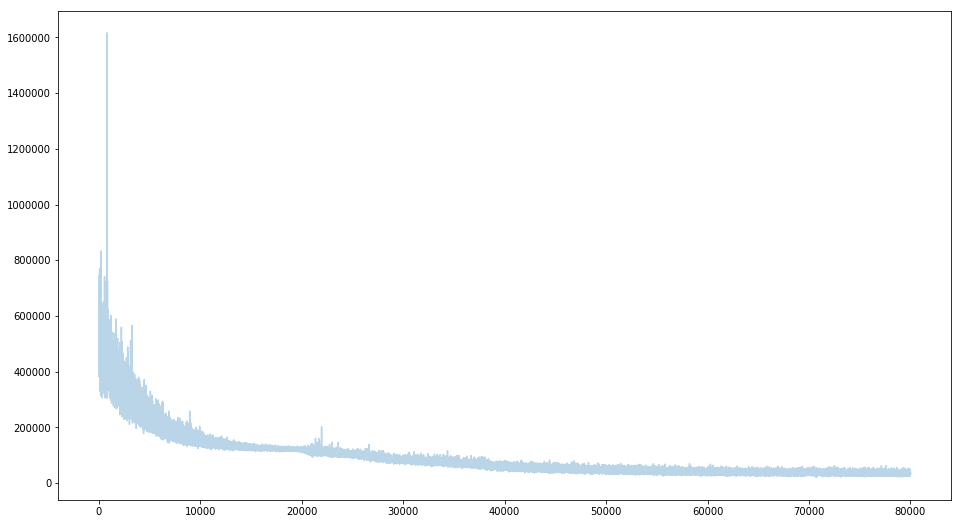

In [42]:
plt.figure(figsize=(16,9))
plt.plot(advi.hist, alpha=.3);

### Important to note
Calling `lasagne.layers.get_output` we in fact get symbolic output of the model. The inferred approximation is not yet applied. Good news are that `pymc3.variatonal` is designed to meet the needs of Bayesian deep learning. It is pretty easy to make it work with minimal efforts and lines of code.

In [43]:
from theano.configparser import change_flags

# The right way to compile a function without changing important pymc3 flag `compute_test_value='raise'`
with change_flags(compute_test_value='ignore'):
    # create symbolic input image
    inpimg = tt.tensor4('input')
    # number of samples for posterior predictive distribution
    it = tt.iscalar('i')
    # posterior predictive probability
    _prediction = gelato.layers.get_output(network)
    # then replacements follow
    prediction = advi.approx.apply_replacements(
        _prediction, deterministic=True, 
        # you can replace minibatch tensor with symbolic input
        more_replacements={input_var:inpimg})
    
    predictions = advi.approx.sample_node(
        _prediction, it, 
        more_replacements={input_var:inpimg})
    # That is it, finally we compile both functions
    predictions_f = theano.function([inpimg, theano.In(it, 's', 10)], predictions)
    prediction_f = theano.function([inpimg], prediction)

## Making predictions

There are different approaches to make decisions under Bayesian setup. One can use __MAP__ esimation for prediction, other options are to use mean of the posterior or predictive distribution and integrate out any statistics, usually mean or mode. I'll compare MAP and posterior predictive mode

In [44]:
from scipy.stats import mode
y_pred_MAP = np.argmax(prediction_f(X_test), axis=1)
error_under_MAP = y_pred_MAP != y_test
error_rate_under_MAP = error_under_MAP.mean()

# distribution for probabilistic predictions
y_preds_posterior = predictions_f(X_test, 100)
# take distribution for modes
# than integrate out mode for modes
y_pred_posterior = mode(np.argmax(y_preds_posterior, axis=-1), axis=0).mode[0]
error_under_posterior = y_pred_posterior != y_test
error_rate_under_posterior = error_under_posterior.mean()

In [45]:
print('MAP                      : %f' % error_rate_under_MAP)
print('predictive posterior mode: %f' % error_rate_under_posterior)

MAP                      : 0.095900
predictive posterior mode: 0.074800


Seems like MAP estimation may be not the best way to predict. On the other hand it is much faster

In [46]:
def check_the_error_at(idx):
    print('true:', y_test[error_under_posterior][idx],'prediction:', y_pred_posterior[error_under_posterior][idx])
    plt.gray();plt.matshow(X_test[error_under_posterior][idx][0]);plt.show();

true: 3.0 prediction: 2


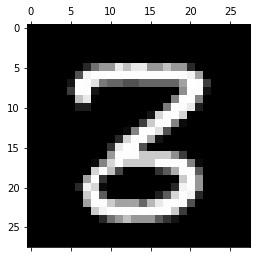

In [47]:
check_the_error_at(0)

true: 9.0 prediction: 4


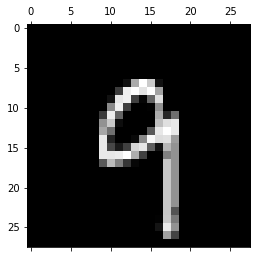

In [48]:
check_the_error_at(1)

# Uncertainty
From a glance uncertainty is not important. But I'll show that it can used for making decisions.


## Simple variance 
Let's calculate average variance for probability predictions in correct pedictions and wrong predictions. I don't use Chi squared statistics to illustrate the difference as [@twiecki](https://github.com/twiecki) did. But still, this picture gives an evidence that mistakes are done with more quantity of uncertainty and thus can be potentially treated as problebatic examples.

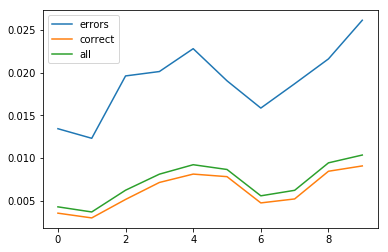

In [49]:
plt.plot(y_preds_posterior.var(0)[error_under_posterior].mean(0), label='errors')
plt.plot(y_preds_posterior.var(0)[~error_under_posterior].mean(0), label='correct')
plt.plot(y_preds_posterior.var(0).mean(0), label='all')
plt.legend()

Wow, variance seems to be much higher for pictures where error was done

## Expected error rate (Inconsistency in predictions)

We can get the posterior distribution for predictions. That gives a lot of information for us. When we constructed `y_pred_posterior` we minimized that expected rate of error, taking the mode of the predictive distribution. Note that is true for categorical predictions. For regression problem with L2 loss one preferes to integrate out mean of the posterior.

__Disclamer__: that's not exactly the expected error for object classification but for estimating the right statistic of distribution. In out case we estimate mode for categorical distribution. This error is about predicting wrong mode and thus taking another desision.

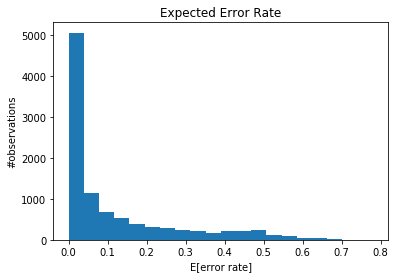

In [50]:
y_preds_labels = np.argmax(y_preds_posterior, axis=-1)
prediction_expected_error_rate = (y_preds_labels != y_pred_posterior).mean(0)
plt.hist(prediction_expected_error_rate, bins=20)
plt.title('Expected Error Rate');
plt.xlabel('E[error rate]')
plt.ylabel('#observations')

Seems like our model is not always confident in predictions and is aware of it. Let's check how often it happens so

In [51]:
((prediction_expected_error_rate != 0) == error_under_posterior).mean()

0.377

In 37% cases our model is not confident enough and it leeds to mistake. 

## High confident errors
Next. How often is out model overconfident? In other words it seems all to be okay but we have an error.

In [52]:
(prediction_expected_error_rate[error_under_posterior] == 0).mean()

0.0053475935828877002

Good news, It happens pretty rare, exactly 4 times.

In [53]:
(prediction_expected_error_rate[error_under_posterior] == 0).sum()

4

In [54]:
houston_we_have_a_problem = prediction_expected_error_rate[error_under_posterior] == 0

In [55]:
def problem_display():
    for i in range(houston_we_have_a_problem.sum()):
        print('true:', y_test[error_under_posterior][houston_we_have_a_problem][i],
              'prediction:', y_pred_posterior[error_under_posterior][houston_we_have_a_problem][i])
        plt.gray();plt.matshow(X_test[error_under_posterior][houston_we_have_a_problem][i][0]);plt.show();

true: 7.0 prediction: 2


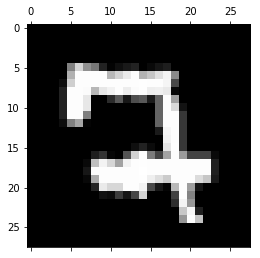

true: 7.0 prediction: 4


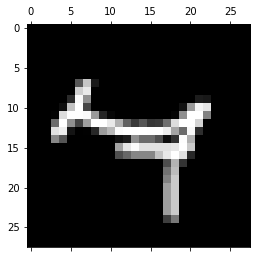

true: 6.0 prediction: 0


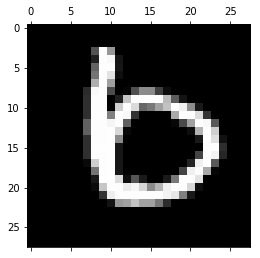

true: 3.0 prediction: 7


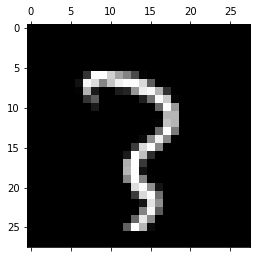

In [56]:
problem_display()

I would rather agree with my network sometimes :)

## Low confidence predictions
Let's see where model estimates the distribution over classes worst

In [57]:
top_three = np.argsort(prediction_expected_error_rate)[-3:][::-1]

In [58]:
top_three

array([9182, 9254, 7991])

In [59]:
def low_confidence_examples_display():
    for i in top_three:
        print('true:', y_test[i],
              'prediction:', y_pred_posterior[i],
              'expected error rate:', prediction_expected_error_rate[i]
             )
        plt.gray();plt.matshow(X_test[i][0]);plt.show();

true: 5.0 prediction: 7 expected error rate: 0.78


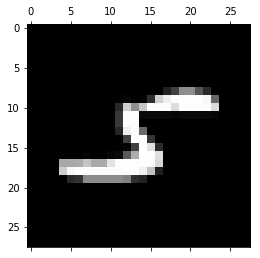

true: 4.0 prediction: 6 expected error rate: 0.75


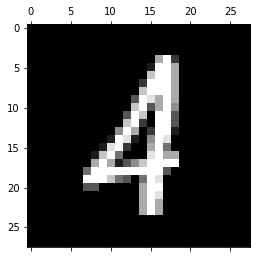

true: 2.0 prediction: 9 expected error rate: 0.74


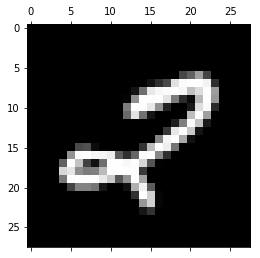

In [60]:
low_confidence_examples_display()

That's done, I hope model confidence does not seem such vague now. Thank you for reading.